In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.8.2


# 1. Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

# Global Variables
RAW_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Raw_Dataset"
CLEAN_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Clean_Dataset"
TRAIN_PATH = os.path.join(CLEAN_DATASET_PATH, 'train')
DEV_PATH = os.path.join(CLEAN_DATASET_PATH, 'dev')
# TEST_PATH = os.path.join(DATASET_SPLIT_PATH, 'test')
NUM_OF_PLANTS = len(os.listdir(RAW_DATASET_PATH))

print('Total jenis tanaman herbal:', NUM_OF_PLANTS)

Total jenis tanaman herbal: 18


In [4]:
from tensorflow.keras.utils import image_dataset_from_directory as IMFD

LABEL_MODE = 'categorical' # Use categorical_crossentropy loss function
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

def CreateTrainValGenerator(train_path, dev_path, label_mode, color_mode, batch_size, image_size, seed):
  train_ds = IMFD(
                    train_path,
                    label_mode=label_mode,
                    color_mode=color_mode,
                    batch_size=batch_size,
                    image_size=image_size,
                    seed=seed,
                  )

  val_ds = IMFD(
                  dev_path,
                  label_mode=label_mode,
                  color_mode=color_mode,
                  batch_size=batch_size,
                  image_size=image_size,
                  seed=seed,
                )
  return train_ds, val_ds

train_ds, val_ds = CreateTrainValGenerator(TRAIN_PATH, DEV_PATH, LABEL_MODE, COLOR_MODE, BATCH_SIZE, IMAGE_SIZE, SEED)
plant_names = train_ds.class_names
print('\nClass Names:\n{}'.format(plant_names))

Found 1679 files belonging to 18 classes.
Found 417 files belonging to 18 classes.

Class Names:
['Andong', 'Bayam Duri', 'Binahong', 'Cincau Hijau', 'Jeruk Nipis', 'Kelor', 'Kemangi', 'Kumis Kucing', 'Meniran', 'Mint', 'Pandan', 'Pepaya', 'Sambiloto', 'Sembung', 'Serai', 'Singkong', 'Sirih', 'Talas']


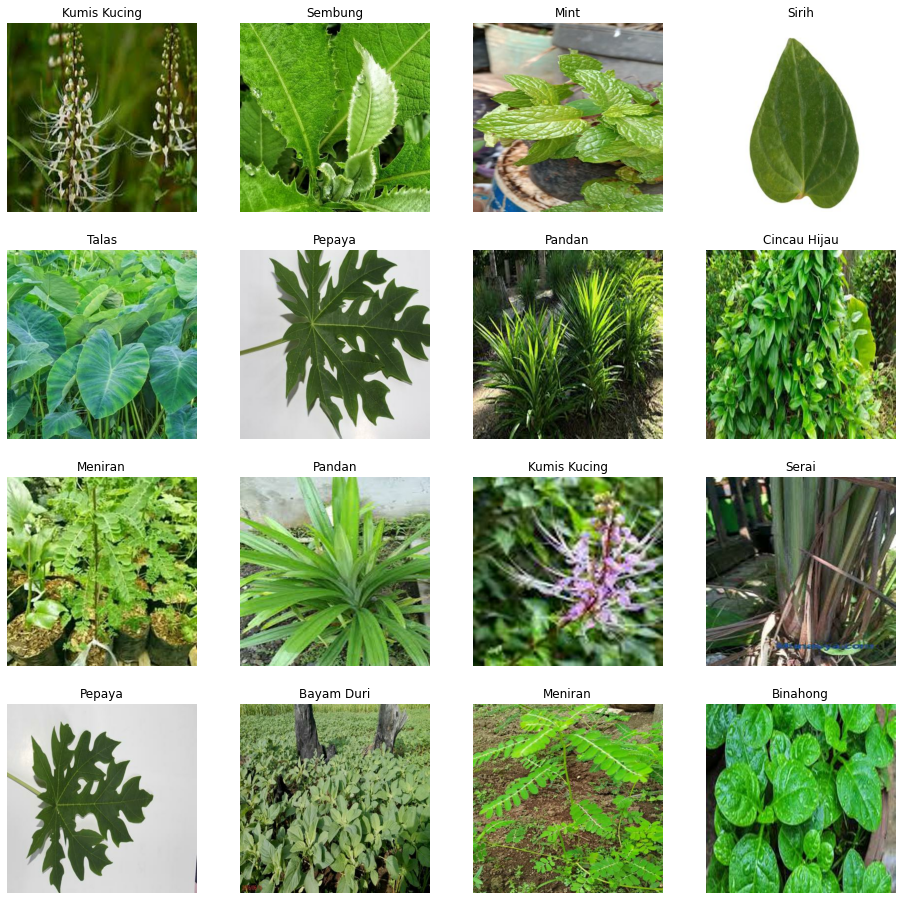

In [5]:
import matplotlib.pyplot as plt

def PlotDatasetBatchImages(dataset, plants_list): 
  plt.figure(figsize=(16, 16)) 
  for images, labels in dataset.take(1):
    for i in range(16): # Minimum 16 BATCH_SIZE, if less change accordingly
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_index = np.argmax(labels[i]) # One-hot encoding
      plt.title(plants_list[class_index])
      plt.axis("off")

PlotDatasetBatchImages(train_ds, plant_names)

In [6]:
# Check Shape per batch

for image_batch, labels_batch in train_ds:
  print('Batch Image Shape:', image_batch.shape)
  print('Batch Labels Shape:', labels_batch.shape)
  break

Batch Image Shape: (32, 384, 384, 3)
Batch Labels Shape: (32, 18)


# 2. Model Building

In [7]:
# EfficientNetV2 Base Model

INPUT_SHAPE = (384, 384, 3)

def CreateBaseModel(input_shape):
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                                                                      include_top=False,
                                                                      weights='imagenet',
                                                                      input_shape=input_shape,
                                                                      include_preprocessing=True
                                                                    )
  base_model.trainable = False
  return base_model

base_model = CreateBaseModel(INPUT_SHAPE)
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [8]:
# Functional API for Keras Model Building

def CreateFinalModel(base_model, input_shape, num_of_plants):
  inputs = keras.Input(shape=input_shape)
  
  # Data Augmentation (Training Only)
  x = tf.keras.layers.RandomFlip("horizontal")(inputs)
  x = tf.keras.layers.RandomRotation(
                                      (-0.2, 0.2),
                                      fill_mode='reflect',
                                      interpolation='bilinear',
                                    )(x)
  x = tf.keras.layers.RandomTranslation(
                                        (-0.15, 0.15),
                                        (-0.15, 0.15),
                                        fill_mode='reflect',
                                        interpolation='bilinear',
                                    )(x)
  
  # Base Model Instantiation
  x = base_model(x, training=False)

  # Custom DNN Model
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dropout(0.6)(x)
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dropout(0.3)(x)

  outputs = keras.layers.Dense(num_of_plants, activation='softmax')(x)

  final_model = keras.Model(inputs, outputs)
  return final_model

final_model = CreateFinalModel(base_model, INPUT_SHAPE, NUM_OF_PLANTS)
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 384, 384, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 384, 384, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 384, 384, 3)      0         
 ranslation)                                                     
                                                                 
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                             

In [9]:
final_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
# Callback for validation accuracy stopping

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print("\nReached 99% validation accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
EPOCHS = 10

history = final_model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/10
53/53 [==============================] - 415s 8s/step - loss: 1.6305 - accuracy: 0.5158 - val_loss: 0.6708 - val_accuracy: 0.8129
Epoch 2/10
53/53 [==============================] - 25s 471ms/step - loss: 0.8076 - accuracy: 0.7504 - val_loss: 0.4998 - val_accuracy: 0.8657
Epoch 3/10
53/53 [==============================] - 25s 467ms/step - loss: 0.6455 - accuracy: 0.7999 - val_loss: 0.4784 - val_accuracy: 0.8537
Epoch 4/10
53/53 [==============================] - 30s 557ms/step - loss: 0.5288 - accuracy: 0.8285 - val_loss: 0.3616 - val_accuracy: 0.8921
Epoch 5/10
53/53 [==============================] - 26s 473ms/step - loss: 0.4982 - accuracy: 0.8440 - val_loss: 0.4058 - val_accuracy: 0.8825
Epoch 6/10
53/53 [==============================] - 25s 463ms/step - loss: 0.4380 - accuracy: 0.8624 - val_loss: 0.4073 - val_accuracy: 0.8849
Epoch 7/10
53/53 [==============================] - 25s 456ms/step - loss: 0.4026 - accuracy: 0.8666 - val_loss: 0.3627 - val_accuracy: 0.8945
E

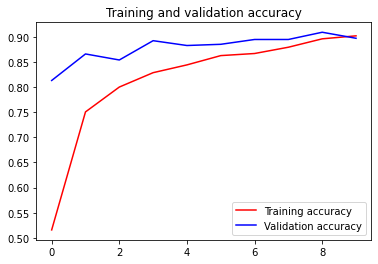

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# 3. Model Evaluation and Uploaded Image Testing

In [ ]:
# Testing Dataset currently unavailable

# final_model.evaluate(test_ds)

In [75]:
# Preprocess Data for model prediction input
from PIL import Image
from numpy import asarray

def PreprocessImageAsArray(path, show_output):
  im = Image.open(path).convert('RGB')
  im = im.resize((384, 384))
  image_as_array = np.expand_dims(asarray(im), axis=0)
  
  if show_output:
    print('Gambar {} selesai di proses.\n'.format(path))
  
  return image_as_array

def PreprocessDanPrediksi(image_path, show_output=True):
  image_as_array = PreprocessImageAsArray(image_path, show_output)
  pred = final_model.predict(image_as_array)
  sorted_ranks = np.flip(np.argsort(pred[0]))
  
  if show_output:
    rank = 1
    print('Prediksi Tanaman:')
    for plant_rank in sorted_ranks:
      print('{:2}. {:16}: {:.3f}'.format(rank, plant_names[plant_rank], pred[0][plant_rank]))
      rank += 1

In [52]:
# Try out model with uploaded images
from google.colab import files
uploaded = files.upload()

In [76]:
IMAGE_PATH = "/content/WhatsApp Image 2022-06-05 at 16.05.58.jpeg"
PreprocessDanPrediksi(IMAGE_PATH)

Gambar /content/WhatsApp Image 2022-06-05 at 16.05.58.jpeg selesai di proses.

Prediksi Tanaman:
 1. Kemangi         : 0.932
 2. Bayam Duri      : 0.027
 3. Sembung         : 0.019
 4. Cincau Hijau    : 0.007
 5. Jeruk Nipis     : 0.006
 6. Meniran         : 0.003
 7. Talas           : 0.002
 8. Singkong        : 0.002
 9. Kumis Kucing    : 0.001
10. Binahong        : 0.001
11. Sambiloto       : 0.000
12. Kelor           : 0.000
13. Mint            : 0.000
14. Sirih           : 0.000
15. Andong          : 0.000
16. Pandan          : 0.000
17. Pepaya          : 0.000
18. Serai           : 0.000


In [77]:
# Benchmark Prediction Time
%timeit PreprocessDanPrediksi(IMAGE_PATH, show_output=False)

10 loops, best of 5: 130 ms per loop


# 4. Final Model Saving (Saved Model Format)


In [64]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 40 kB 4.7 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [86]:
from datetime import datetime
import tensorflowjs as tfjs
import shutil

now = datetime.now()
now_converted = now.strftime("%d-%m-%Y_%H.%M.%S")
final_zip_path = '/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Model_Storage/herbapedia_model_{}'.format(now_converted)
tfjs_target_dir = './output/'

tfjs.converters.save_keras_model(final_model, tfjs_target_dir)
shutil.make_archive(final_zip_path, 'zip', tfjs_target_dir)

'/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Model_Storage/herbapedia_model_05-06-2022_09.49.29.zip'